# Imports

In [1]:
import time
import sys
import random
import pickle
import operator
from itertools import product
from joblib import Parallel, delayed, parallel_backend
from collections import defaultdict

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_random,
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
)

In [3]:
n_jobs = 24 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]

# Functions

In [4]:
def numpy_array_to_iris_df(numpy_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    mask = [np.ones(DIM[1:], dtype=np.bool_) for _ in range(DIM[0])]
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(matrix), mask) for matrix in numpy_array)
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [5]:
def import_voter_model_rust_implementation(path_low, path_high, total_num_samples, num_samples=None):
    num_samples = num_samples if num_samples else total_num_samples
    assert num_samples <= total_num_samples
    low_high_data_lst = [
        np.unpackbits(np.fromfile(path, dtype=np.uint8), bitorder="little")
        .reshape(total_num_samples, X, Y)
        [np.random.choice(total_num_samples, size=num_samples, replace=False)] for path in [path_low, path_high]
    ]
    data = np.stack(low_high_data_lst, axis=1).astype(bool)
    return numpy_array_to_iris_df(data)

In [6]:
def load_synthetic_iris(method, num_samples, path='compressed_iris_matrices'):
    # Load data and randomly select num_samples samples
    loaded_data = np.load(f'{path}_{method}.npz')['data']
    assert loaded_data.shape[0] >= num_samples, f"Requested {num_samples} samples, but only {loaded_data.shape[0]} available."
    indices = np.random.choice(loaded_data.shape[0], num_samples, replace=False)
    return numpy_array_to_iris_df(loaded_data[indices].reshape(num_samples, *DIM))

In [7]:
def update_db(db, iris_df, db_size):
    db_current_size = db.get_stats()['db_size']
    assert (db_size - db_current_size) > 0
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for iris in new_irises:
        db.insert(make_query(iris))
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [8]:
midpoints = np.load('noise_distribution_bin_midpoints.npz')['data']
probabilities = np.load('noise_distribution_probability_distribution.npz')['data']
def sample_noise(midpoints=midpoints, probabilities=probabilities, sample_size=1):
    return np.random.choice(midpoints, size=sample_size, p=probabilities)

In [9]:
def run_single_experiment(i, db, idx, iris, noise, efSearch, K):
    # np.random.seed(i), random.seed(i)
    # iris, random_target_id = iris_df[iris_df['ID'].notna()].sample(1).iloc[0]
    noisy_query = make_query(iris_with_noise(iris, noise_level=noise))
    res = db.search(noisy_query, K, ef=efSearch)
    return next((i for i, (_, num) in enumerate(res) if num == idx), np.inf)

In [10]:
def process_stats(db):
    temp = db.get_stats()['code_run_stats']
    proportions_dict = defaultdict(list)
    for layer, values_list in temp:
        proportions_dict[layer].append(values_list)
    return {layer: pd.DataFrame(data) for layer, data in proportions_dict.items()}

In [11]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

# Configurations

In [12]:
# Constants values
num_experiments = 20
precision_thres = 0.99
K_range = np.arange(10, 101, 10)
max_K = K_range.max()

In [60]:
num_db_elements = np.arange(1000, 10001, 1000)
Ms = [16, 32]
efConstructions = [64, 128]
efSearchs = [128, 256]
parameter_combinations = sorted(list(product(Ms, efConstructions, efSearchs, num_db_elements)))

# Output the total number of combinations for verification
print(f"Total parameter combinations: {len(parameter_combinations)}")

Total parameter combinations: 80


# Stats computation

In [16]:
def check_combination_exists(stats_df, M, efConstruction, efSearch, K, db_size):
    mask = (
        (stats_df['db_size'] == db_size) & 
        (stats_df['K'] == K) &
        (stats_df['M'] == M) & 
        (stats_df['efConstruction'] == efConstruction) &
        (stats_df['efSearch'] == efSearch)
    )
    return mask.any()

In [15]:
iris_df = import_voter_model_rust_implementation(
    path_low='2M_voter_arrays_80k_b45.dat', 
    path_high='2M_voter_arrays_7k_b13.dat', 
    total_num_samples=1000000, 
    num_samples=num_db_elements.max()
)

In [61]:
results_df_path = "stats_df.parquet"
stats_df = pd.read_parquet(results_df_path)
prev_db_size = np.inf
for j, (M, efConstruction, efSearch, db_size) in enumerate(parameter_combinations):
    # Print progress update
    progress_ratio = j / len(parameter_combinations)
    sys.stdout.write(f"\rCurrent progress out of {len(parameter_combinations)} parameter combinations (with {num_experiments} experiments each): {progress_ratio:.1%}")
    sys.stdout.flush()
    
    if check_combination_exists(stats_df, M, efConstruction, efSearch, max_K, db_size):
        continue
    
    if db_size < prev_db_size:
        # Initiate HNSW instance
        db = hnsw.HNSW(
            M=M, 
            efConstruction=efConstruction, 
            m_L=1/np.log(M), 
            distance_func=distance, 
            query_to_vector_func=query_to_vector
        )
        iris_df['Inserted'] = False
    
    # Update the db (use the insertion feature)
    update_db(db, iris_df, db_size)

    # Run num_experiments in parallel (to average the precision over multiple experiments)
    indices, irises = iris_df.loc[iris_df['Inserted'], 'Template'].sample(num_experiments).reset_index().T.values
    noises = sample_noise(sample_size=num_experiments)
    with parallel_backend('threading'):
        results = Parallel(n_jobs=n_jobs)(
            delayed(run_single_experiment)(i, db, indices[i], irises[i], noises[i], efSearch, max_K) for i in range(num_experiments)
        )

    
    # Update results
    rows = []
    for K in K_range:
        curr_results = (results <= K)
        rows.append([db_size, K, M, efConstruction, efSearch, sum(curr_results) / num_experiments, num_experiments])
    new_rows_df = pd.DataFrame(rows, columns=['db_size', 'K', 'M', 'efConstruction', 'efSearch', 'precision', 'num_experiments'])
    stats_df = pd.concat([stats_df, new_rows_df], ignore_index=True)
    stats_df.to_parquet(results_df_path)

    # Update prev_size
    prev_db_size = db_size

Current progress out of 80 parameter combinations (with 20 experiments each): 56.2%

KeyboardInterrupt: 

# Proportion request - Bryan

In [17]:
db = hnsw.HNSW(
    M=64, 
    efConstruction=128, 
    m_L=1/np.log(64), 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)
update_db(db, iris_df, 10000)

In [20]:
stats = process_stats(db)

In [44]:
layer_0 = stats[0].dropna(axis=0, how='all').loc[1000:]
bins = range(1000, 11000, 1000)
labels = [f"{i}-{i+1000}" for i in range(1000, 10000, 1000)]
layer_0['insertion_range'] = pd.cut(layer_0.index, bins=bins, labels=labels, right=False)
layer_0 = layer_0.reset_index().rename(columns={'index': 'insertion_order'})
layer_0 = pd.melt(layer_0, id_vars=['insertion_order', 'insertion_range'], var_name='vertex', value_name='proportion').dropna()

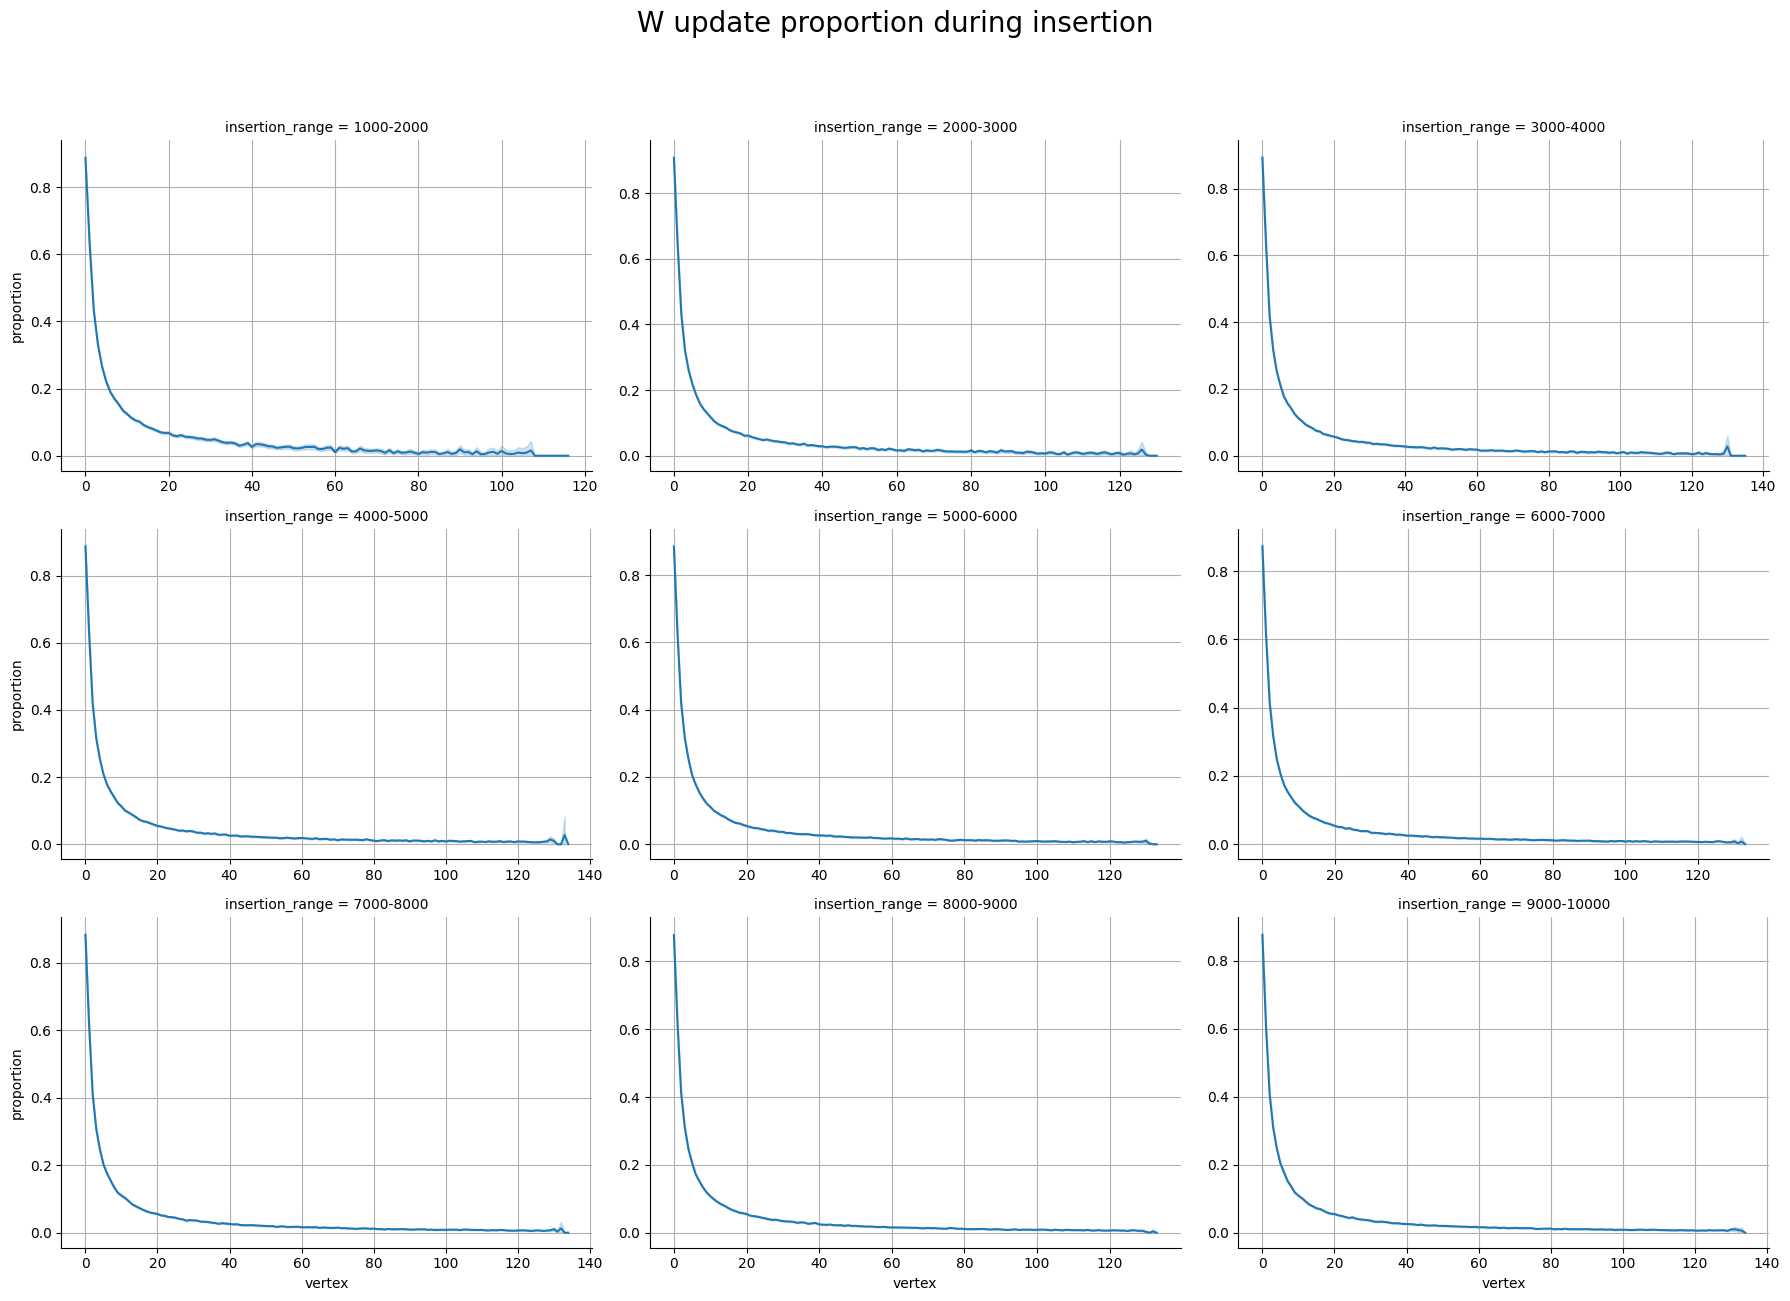

In [59]:
facetgrid = sns.FacetGrid(layer_0, col='insertion_range', col_wrap=3, height=4, aspect=1.5, sharex=False, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x='vertex', y='proportion')
[ax.grid(True) for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle('W update proportion during insertion', fontsize=20, y=1.08)
plt.show()

# Analysis

In [11]:
stats_df = pd.read_parquet('temp_stats_df.parquet')

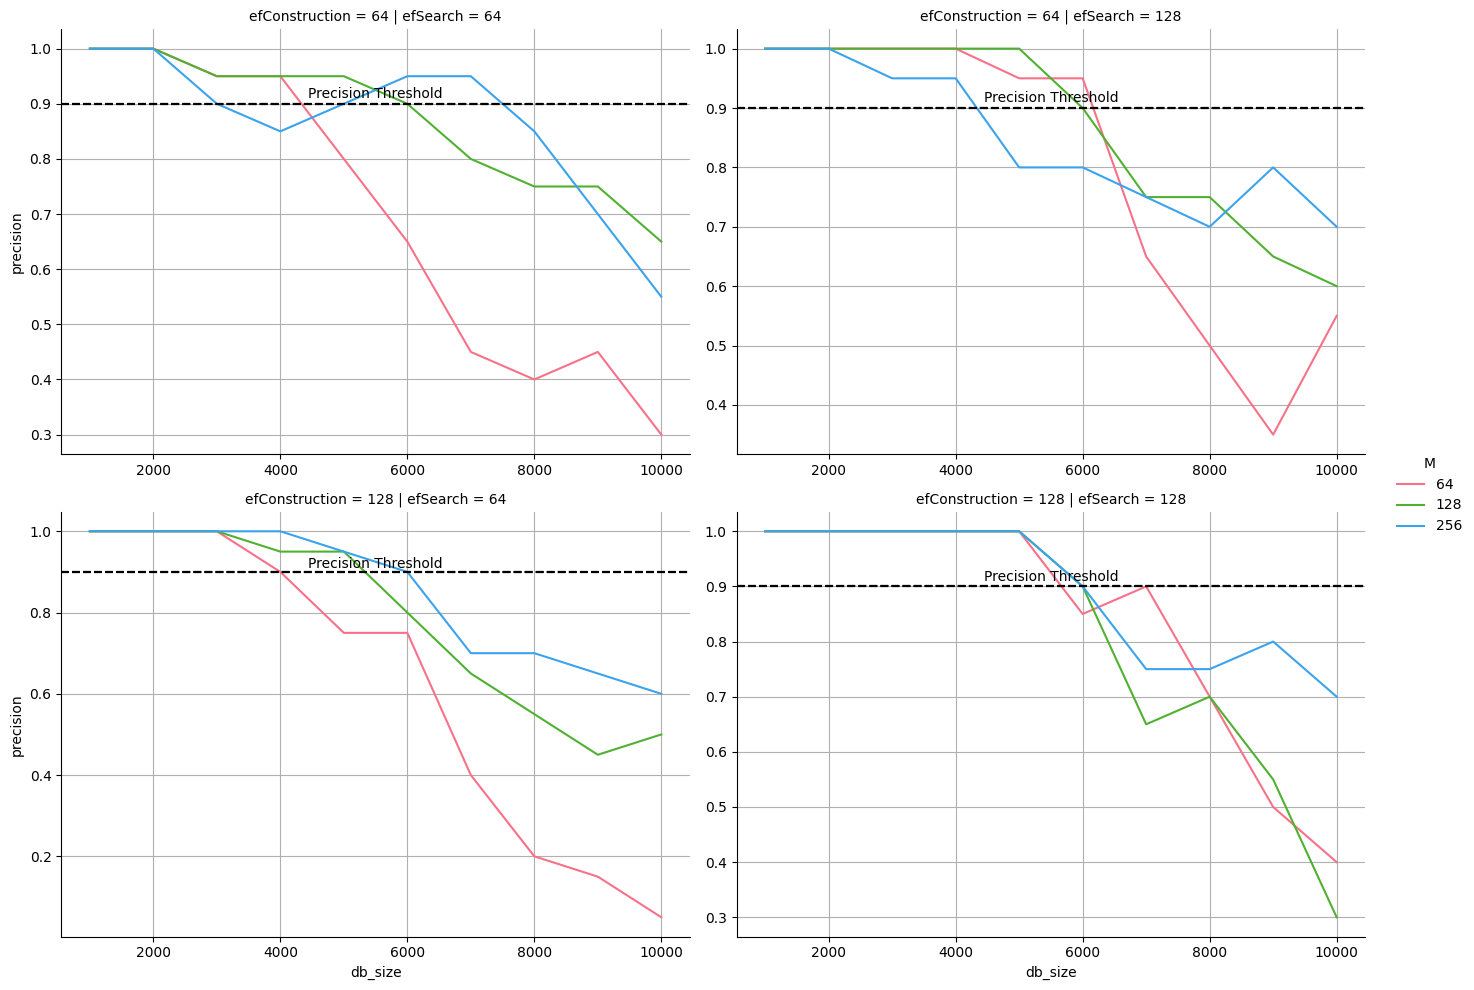

In [8]:
facetGrid = sns.FacetGrid(stats_df, col='efSearch', row='efConstruction', hue='M', palette='husl', sharex=False, sharey=False, height=5, aspect=1.4)
facetGrid.map_dataframe(sns.lineplot, x='db_size', y='precision')
[
    (
        ax.grid(), ax.text(np.mean(num_db_elements), precision_thres+0.01, "Precision Threshold", ha='center')
    ) for ax in facetGrid.axes.flatten()
]
facetGrid.add_legend()
facetGrid.refline(y=precision_thres, linestyle='--', color='k')
plt.show()

1. Analyze the behavior of the noise accross different iris samples over same person (Aurel suggestion: look at the histogram of the hamming distance between the samples - looks like a gradually decending distribution from 0 to 0.4 starts flats then goes down)
2. creating a noisy sample idea - use the previously described distribution to pick noise level, then "flip" the required amount of pixels in order to reach that noise level in terms of hamming distance
3. difference between the hawk-pack and the hnsw-demo: the choice of efConstruction per layer (constant (1) in hnsw-demo and variates in hawk-pack)
4. Second task regarding noise levels - add a test in which the noise level differs and we test how it effects our precision (i.e. model the change in accuracy in relation to different noise levels from 0 to 0.4)

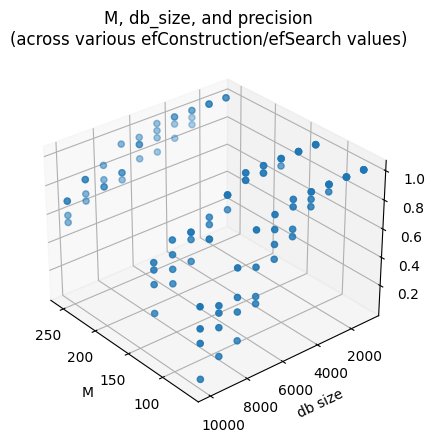

In [61]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(stats_df['M'], stats_df['db_size'], stats_df['precision'])
ax.view_init(elev=30, azim=140)
ax.set_xlabel('M')
ax.set_ylabel('db size')
ax.set_zlabel('precision')
ax.set_title('M, db_size, and precision\n(across various efConstruction/efSearch values)');

# Modeling

In [104]:
# Possibly cut data only to subsample that reaches accuracy requirments
# stats_df['sufficient'] = stats_df['precision'] > precision_thres 

In [124]:
def func(X, a, b, c): # Adjust according to results on actual data
    x, y = X
    return a + b * x + c * y**2

In [125]:
# Inputs 
x_var = 'M'
y_var = 'db_size'

In [126]:
other_variables = sufficient_df.columns.drop([x_var, y_var]).to_list()
curve_fit_input = stats_df.groupby([x_var, y_var])['precision'].mean().reset_index()

In [127]:
x, y = curve_fit_input[x_var].values, curve_fit_input[y_var].values
target = curve_fit_input['precision'].values

In [128]:
params, covariance = curve_fit(func, (x, y), target)
precision_approx = func((x, y), *params)

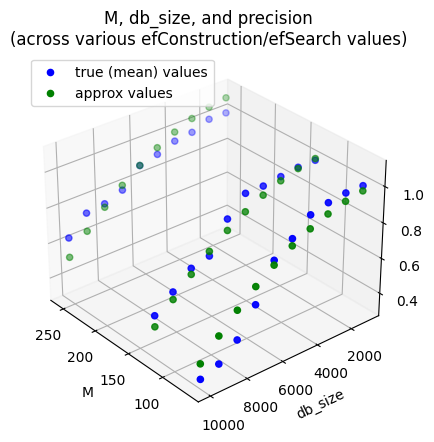

In [130]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(x, y, target, color='blue', label='true (mean) values')
ax.scatter(x, y, precision_approx, color='green', label='approx values')
ax.view_init(elev=30, azim=140)
ax.set_xlabel(x_var)
ax.set_ylabel(y_var)
ax.set_zlabel('precision')
ax.set_title(f'{x_var}, {y_var}, and precision\n(across various efConstruction/efSearch values)');
ax.legend();